In [1]:
from matplotlib import pyplot as plt
from torch import Tensor

from src.common.log import logger
from src.dataset.tno_dataset_collection import TnoDatasetCollection
from src.inverse_problems.compressed_sensing_problem import (
    TotalEmissionsCompressedSensingExperiment,
)
from src.inverse_problems.footprints.footprint_loader import load_gaussian_plume_footprint
from src.inverse_problems.inverse_problems_solver import (
    BasisPursuitSolver,
    GenerativeModelSolver,
    SparsityTransform,
)
from src.models.common.metrics import mse, relative_error, ssim
from src.plotting.city_emission_field_plot import plot_emission_field_tensor

In [2]:
CITY = "Paris"

x = TnoDatasetCollection().get_single_case_study_city_emission_field(city=CITY, year=2018).sum(dim=0)

[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2015_highres_by_city.csv'
[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2018_highres_by_city.csv'                                                                                      
[INFO] > Test Set has 13 unique cites!                                                                                                                                                                                                 
	Magdeburg, Reims, Dresden, Prague, Aachen, Duisburg, Győr, Innsbruck, Gdynia, Siegen, Hamburg, Szczecin, Großzschocher
[INFO] > Validation Set has 15 unique cites!
	Wałbrzych, Bielefeld, Kalisz, Brussels, Angers, Erfurt, Frankfurt am Main, Nijmegen, Southampton, Linz, Zielona Góra, Koblenz, Ingolstadt, Kassel, Bydgoszcz
[INFO] > Training Set has 74 unique cites!
	Le Havre, Leeds, Readin

In [3]:
sensing_matrix = load_gaussian_plume_footprint(num_stations=50)

snr = 10_000

problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
    x,
    Tensor(sensing_matrix),
    snr=snr
)

In [4]:
bp_solver = BasisPursuitSolver(verbose=False)
bp_solver_dwt = BasisPursuitSolver(transform=SparsityTransform.DWT, verbose=False)
bp_solver_dct = BasisPursuitSolver(transform=SparsityTransform.DCT, verbose=False)

gen_solver_256 = GenerativeModelSolver.from_vae_model_name("256", plot_loss=True)
gen_solver_512 = GenerativeModelSolver.from_vae_model_name("512", plot_loss=True)
gen_solver_1024 = GenerativeModelSolver.from_vae_model_name("1024", plot_loss=True)
gen_solver_2048 = GenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)

gen_solver_512_munich = GenerativeModelSolver.from_vae_model_name("512_munich", plot_loss=True)
gen_solver_2048_munich = GenerativeModelSolver.from_vae_model_name("2048_munich", plot_loss=True)

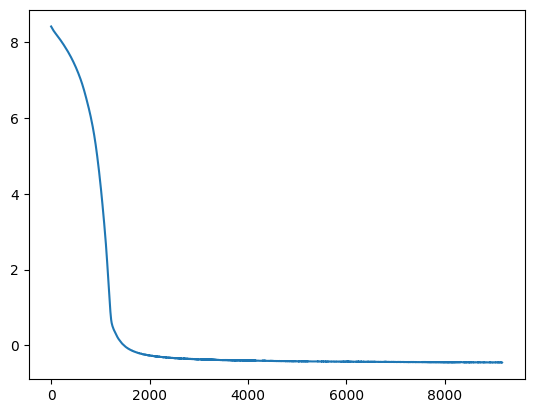

In [5]:
x_rec = problem.solve(gen_solver_2048_munich)

In [6]:
logger.info(f"MSE={mse(x, x_rec):.3f}")
logger.info(f"SSIM={ssim(x, x_rec):.3f}")
logger.info(f"Relative Error={100 * relative_error(x, x_rec):.3f}%")

[INFO] > MSE=9.376
[INFO] > SSIM=0.581
[INFO] > Relative Error=40.583%


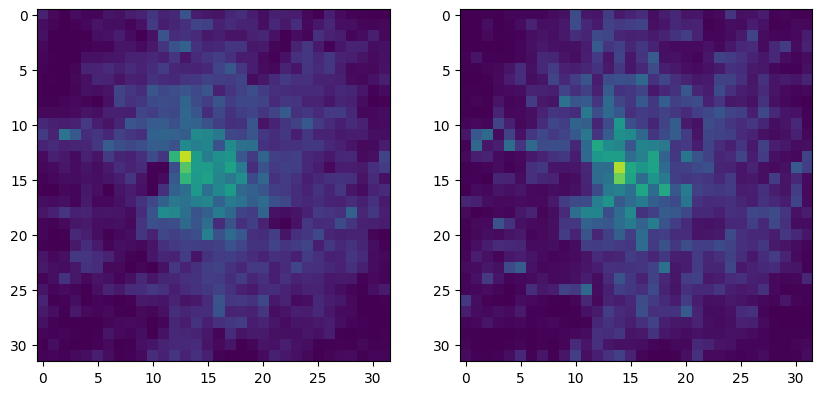

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

vmax = 1.1 * float(x.max())

plot_emission_field_tensor(ax=ax1, emission_field=x, vmax=vmax)
plot_emission_field_tensor(ax=ax2, emission_field=x_rec, vmax=vmax)